# Stock predict
평가 산식: NMAE * 100


평가 (Public, Private score)
- public score: 11월 1일 ~ 11월 5일 주식 종료 예측값
- private score: 11월 29일 ~ 12월 3일 주식 종료 예측값

In [2]:
!pip install finance-datareader

In [3]:
!pip install OpenDartReader

In [4]:
# for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/Colab_Notebooks/dacon/stockpredict

/content/drive/MyDrive/Colab_Notebooks/dacon/stockpredict


---------------

In [6]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr
import OpenDartReader
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import mean_absolute_error

In [7]:
path = './'
list_name = 'stock_list.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [8]:
start_date = '20210104'
end_date = '20211029'
sample_code = '005930'
stock = fdr.DataReader(sample_code, start = start_date, end = end_date)
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170
...,...,...,...,...,...,...
2021-10-25,69900,70600,69500,70200,10029621,-0.002841
2021-10-26,70600,71500,70400,71100,10528252,0.012821
2021-10-27,71000,71000,70000,70100,10295316,-0.014065


In [ ]:
fdr.chart.plot(stock)

In [ ]:
# volume의 어제자와 차이(1차분)
fdr.chart.plot(stock)

In [ ]:
# volume의 지난주와이 차이(5칸 간격의 1차분)
fdr.chart.plot(stock)

In [9]:
start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'WEEKDAY of "end_date" : {pd.to_datetime(end_date).weekday()}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
WEEKDAY of "end_date" : 4
NUM of WEEKS to "end_date" : 43
HOW MANY "Business_days" : (215, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [ ]:
stock["Volume"] = stock["Volume"] - stock["Volume"].shift(5).fillna(0)

In [ ]:
# 이미 영업일만 가져오는듯

# bday_idx = Business_days["Date"]
# bday_stock = stock.reindex(stock.index.intersection(bday_idx))
# fdr.chart.plot(bday_stock)

# OpenDART 기업 재무재표


In [ ]:
# https://opendart.fss.or.kr/
api_key = '8e8ab3b65172cf119b55c60984b4f7451b1e3b6b'
dart = OpenDartReader(api_key)

[OpenDART 개발가이드](https://opendart.fss.or.kr/guide/detail.do?apiGrpCd=DS003&apiId=2019017)

|키|명칭|설명|
|---|---|---|
|corp_code|고유번호|공시대상회사의 고유번호(8자리)|
|bsns_year|사업연도|사업연도(4자리) ※ 2015년 이후 부터 정보제공|
|reprt_code|보고서코드|1분기보고서 : 11013|
|||반기보고서 : 11012|
|||3분기보고서 : 11014|
|||사업보고서 : 11011|

In [ ]:
dart.finstate_all(corp=stock_list.loc[0, '종목코드'], bsns_year=2021, reprt_code=11012)

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
0,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CurrentAssets,유동자산,-,제 53 기 반기말,191118524000000,제 52 기말,198215579000000,1,NaN,NaN,NaN,NaN
1,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CashAndCashEquivalents,현금및현금성자산,-,제 53 기 반기말,30683788000000,제 52 기말,29382578000000,2,NaN,NaN,NaN,NaN
2,20210817001416,11012,2021,00126380,BS,재무상태표,dart_ShortTermDepositsNotClassifiedAsCashEquiv...,단기금융상품,-,제 53 기 반기말,77777032000000,제 52 기말,92441703000000,3,NaN,NaN,NaN,NaN
3,20210817001416,11012,2021,00126380,BS,재무상태표,-표준계정코드 미사용-,단기상각후원가금융자산,-,제 53 기 반기말,2350399000000,제 52 기말,2757111000000,4,NaN,NaN,NaN,NaN
4,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CurrentFinancialAssetsAtFairValueThr...,단기당기손익-공정가치금융자산,-,제 53 기 반기말,49720000000,제 52 기말,71451000000,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|기타자본항목,제 53 기 반기,-6226066000000,NaN,NaN,13,NaN,제 52 기 반기,-3721095000000,NaN
180,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|매각예정분류기타자본항목,제 53 기 반기,0,NaN,NaN,13,NaN,제 52 기 반기,0,NaN
181,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|이익잉여금 [member],제 53 기 반기,275085185000000,NaN,NaN,13,NaN,제 52 기 반기,260165053000000,NaN
182,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|자본금 [member],제 53 기 반기,897514000000,NaN,NaN,13,NaN,제 52 기 반기,897514000000,NaN


# 검색어 트랜드 살피기

- google trend
- 크롤링 자동화는 데이터를 살펴 본 다음에..

In [10]:
df_trend = pd.read_csv("./google_trend_samsung.csv", header=1, index_col=0)
df_trend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 2020-11-29 to 2021-11-14
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   삼성전자: (대한민국)  51 non-null     int64
dtypes: int64(1)
memory usage: 816.0+ bytes


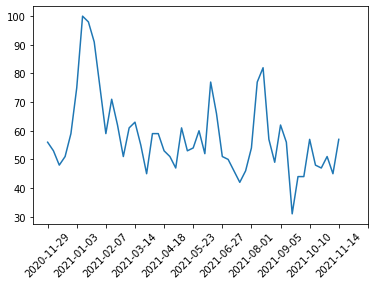

In [11]:
plt.plot(df_trend)
plt.xticks(np.arange(0,60,5), rotation=45)
plt.show()

##0) Baseline code 따라하기
요일별 종가("Closed")를 linear regression로 예측
- 이번주 데이터로 다음주 예측

In [ ]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample.Close = sample.Close.ffill()
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
02,55500.0,55800.0,56800.0,58600.0,59500.0
03,60000.0,60000.0,59000.0,60700.0,61300.0
04,62400.0,61400.0,62300.0,60800.0,60800.0
05,60800.0,58800.0,59100.0,57200.0,56400.0
06,57200.0,58900.0,59500.0,61100.0,60400.0


In [ ]:
sample.tail()

weekday,0,1,2,3,4
weeknum,,,,,
48,67500.0,67700.0,66600.0,68000.0,68200.0
49,66700.0,67800.0,69500.0,69700.0,71500.0
50,72900.0,71700.0,73900.0,72900.0,73400.0
51,73800.0,73800.0,73800.0,73300.0,73000.0
52,73000.0,72300.0,73900.0,77800.0,77800.0


In [ ]:
x = sample.iloc[0:-2].to_numpy()
x.shape

(49, 5)

In [ ]:
y = sample.iloc[1:-1].to_numpy()
y_0 = y[:,0]
y_1 = y[:,1]
y_2 = y[:,2]
y_3 = y[:,3]
y_4 = y[:,4]

y_values = [y_0, y_1, y_2, y_3, y_4]

In [ ]:
x_public = sample.iloc[-2].to_numpy()

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

predictions = []
for y_value in y_values :
    model.fit(x,y_value)
    prediction = model.predict(np.expand_dims(x_public,0))
    predictions.append(prediction[0])

In [ ]:
print(f"y_pred : {predictions}\nvs\ny_public : {list(sample.iloc[-1].values)}")

y_pred : [73912.14870585549, 73508.90894414231, 73858.77902491373, 73367.23881923566, 73322.49774082401]
vs
y_public : [73000.0, 72300.0, 73900.0, 77800.0, 77800.0]


# **Utility functions

In [128]:
def nmae(y_true, y_pred):
  """
  Normalized Mean Absoulte Error * 100

  Returns:
    eval_name, eval_result, is_higher_better
  """
  mae = mean_absolute_error(y_true, y_pred)
  abs_mean = np.mean(np.abs(y_true))
  return "NMAE", (mae / abs_mean) * 100, False

In [ ]:
nmae(list(sample.iloc[-1].values), predictions)

('NMAE', 0.02954253485865636, False)

In [ ]:
# ADF test
def adf_test(data):
  result = adfuller(data)
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'critical_values: {result[4]}')

In [ ]:
def plot_two_y_axis(first_data, second_data, f_name="first", s_name="second"):
  # create figure and axis objects with subplots()
  fig,ax = plt.subplots()
  # make a plot
  ax.plot(first_data, color="red")
  # set x-axis label
  ax.set_xlabel("date")
  fig.autofmt_xdate(rotation=45)
  # set y-axis label
  ax.set_ylabel(f_name,color="red")

  # twin object for two different y-axis on the sample plot
  ax2=ax.twinx()
  # make a plot with different y-axis using second axis object
  ax2.plot(second_data, color="blue")
  ax2.set_ylabel(s_name,color="blue")
  plt.show()

# 1) LightGBM
- feature를 만들어서 lgbm regression으로 시도해본다.
- hyperparams는 grid search나 bayesian optimization을 시도해본다.
- 성능이 안좋더라도, feature importance를 통해 feature의 효용성을 확인해본다.

In [ ]:
from lightgbm import LGBMRegressor

### features & preprocess
- 시가 ~ 종가 : Change
- Volume : 추세를 나타내는게 효과적일 듯?
- High ~ Low : 
- 상승 or 하락? : Change 수치로 대체될듯

In [ ]:
data = stock.copy()

In [ ]:
X = data[["Change","Close","Volume"]]

In [ ]:
# 미래 1주일 뒤(=각 날짜마다 5일 뒤)를 예측? -> 단순 다음주는 x.. 너무 naive한 접근법인듯. 그러나 어찌되었든 5일 후까지를 예측하는 문제이니, 5칸 영역 밖에서 해결해야한다.
# 어쨌든 중요한 점은 X feature에 최근 흐름을 담아야함
y = data["Close"].shift(-5).dropna()
y_train = y.iloc[:-20]
y_test = y.iloc[-20:]

In [ ]:
X_train = X.reindex(X.index.intersection(y_train.index))
X_test = X.reindex(X.index.intersection(y_test.index))

### model

In [ ]:
lgbm_model = LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
lgbm_model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=nmae,
        early_stopping_rounds=5)

[1]	valid_0's l2: 2.74411e+08	valid_0's NMAE: 0.226885
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 2.65491e+08	valid_0's NMAE: 0.223077
[3]	valid_0's l2: 2.57597e+08	valid_0's NMAE: 0.219651
[4]	valid_0's l2: 2.50545e+08	valid_0's NMAE: 0.216536
[5]	valid_0's l2: 2.44132e+08	valid_0's NMAE: 0.213663
[6]	valid_0's l2: 2.37193e+08	valid_0's NMAE: 0.21052
[7]	valid_0's l2: 2.31073e+08	valid_0's NMAE: 0.207708
[8]	valid_0's l2: 2.25622e+08	valid_0's NMAE: 0.205163
[9]	valid_0's l2: 2.19866e+08	valid_0's NMAE: 0.202449
[10]	valid_0's l2: 2.15208e+08	valid_0's NMAE: 0.200216
[11]	valid_0's l2: 2.10833e+08	valid_0's NMAE: 0.198095
[12]	valid_0's l2: 2.06815e+08	valid_0's NMAE: 0.196159
[13]	valid_0's l2: 2.0292e+08	valid_0's NMAE: 0.194231
[14]	valid_0's l2: 1.98536e+08	valid_0's NMAE: 0.192051
[15]	valid_0's l2: 1.94417e+08	valid_0's NMAE: 0.189979
[16]	valid_0's l2: 1.91128e+08	valid_0's NMAE: 0.188331
[17]	valid_0's l2: 1.87703e+08	valid_0's NMAE: 0.18657

LGBMRegressor(learning_rate=0.05, n_estimators=20)

In [ ]:
y_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration_)
# eval
print('NMAE * 100 :', (nmae(y_test, y_pred))[1])

# feature importances
print(
    'Feature importances:', 
    [pair for pair in zip(X.columns, list(lgbm_model.feature_importances_))]
)

NMAE * 100 : 18.237378574862305
Feature importances: [('Change', 20), ('Close', 96), ('Volume', 37)]


-> validation set에서는 성능이 잘나오는데, 테스트셋의 성능이 최악이다.

-> feature를 전혀 가공하지 않았기 때문도 있지만, 문제 정의 자체가 힘든 듯 : 1일 후~ 5일 후까지 예측 필요. 베이스라인 코드와 같이, 1일후 모델 ~ 5일후 모델 총 5개를 만들어도 되겠으나, 개별적인 데이터 모델링이 필요해보인다.

# 2) Sequence model
- 모델은 간단한 LSTM을 쓰고, 추후에 다른 시퀀스나 어탠션을 넣어본다.
- DNN 레이어 자체보다는, 데이터 가공에 신경써보자

In [12]:
## X sequence size, Y sequence size 정의
step_size = 20 # 4주치?
unit_size = 5 # 총 5일 예측할 것임

"""
L : total length
W : x step size(input sequence Window size)
P : y unit size(Predicting sequence size)일때,

=> W만큼 X데이터 시퀀스를 넣어 P만큼의 시퀀스 길이를 예측한다.

X data shape : (L-W+1, W, num_features)
Y data shape : (L-W-P+1, P)
"""

'\nL : total length\nW : x step size(input sequence Window size)\nP : y unit size(Predicting sequence size)일때,\n\n=> W만큼 X데이터 시퀀스를 넣어 P만큼의 시퀀스 길이를 예측한다.\n\nX data shape : (L-W+1, W, num_features)\nY data shape : (L-W-P+1, P)\n'

In [13]:
from sklearn.preprocessing import MinMaxScaler
# from numpy.lib.stride_tricks import as_strided
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

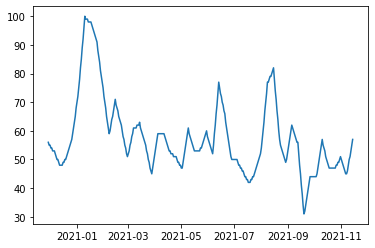

In [54]:
# trend를 동일 인덱스로 맞추기 위한 가공
df_trend.index = df_trend.index.astype("datetime64[ns]")
df_trend = df_trend.resample("D").asfreq()
df_trend = df_trend.interpolate().astype(int)
plt.plot(df_trend)
plt.show()

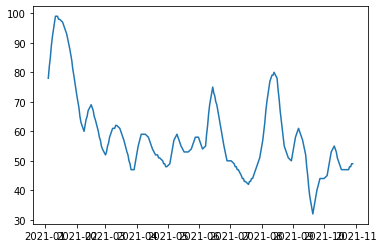

In [57]:
df_trend = df_trend.reindex(Business_days["Date"].astype("datetime64[ns]"))
plt.plot(df_trend)
plt.show()

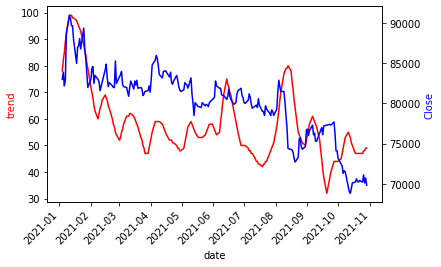

In [81]:
plot_two_y_axis(df_trend, stock["Close"], "trend", "Close")

In [73]:
# pd series로 만들기
df_trend = df_trend[df_trend.columns[0]]

In [99]:
# index 맞추기
common_idx = stock["Close"].index.intersection(df_trend.index)
df_trend = df_trend.reindex(common_idx)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_

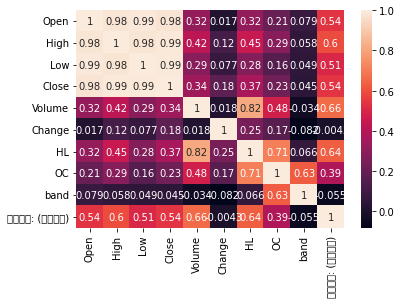

In [114]:
# Correlation 확인
# 여러가지 컬럼을 가공 및 믹스한 feature를 만들어내본다
df_test = stock.copy()
df_test["HL"] = df_test["High"] - df_test["Low"] # High - Low 차이
df_test["OC"] = (df_test["Open"] - df_test["Close"]).abs() # Open, Close 차이
df_test["band"] = df_test["OC"] / df_test["HL"] # High~Low 대비 Open~Close
# df_test["Voldiff"] = (df_test["Volume"] - df_test["Volume"].shift(1)).interpolate().astype(int) # Volume 1차분

df_test = pd.concat([df_test, df_trend], axis=1)
sns.heatmap(df_test.corr(method="pearson"), annot=True)

==> correlation은 큰 의미는 없는듯하다.. Open, High, Low 전부 Close와 유사한 형태로 따라가기때문에 correlation이 높게나오는건 당연한게 아닐까?

Test Statistics: -13.660246469977183
p-value: 1.5262756766053516e-25
critical_values: {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}
Test Statistics: -6.8477958618359684
p-value: 1.724910001233379e-09
critical_values: {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}
Test Statistics: -3.135581701047719
p-value: 0.02402960974968417
critical_values: {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}


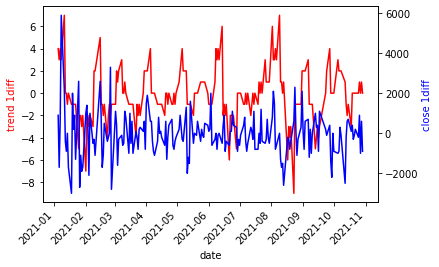

In [101]:
close_diff = (stock["Close"] - stock["Close"].shift(1)).dropna()
adf_test(close_diff)
trend_diff = (df_trend - df_trend.shift(1)).dropna()
adf_test(trend_diff)
adf_test(df_trend)
plot_two_y_axis(trend_diff, close_diff, "trend 1diff", "close 1diff")

### granger causality test

[참고 : granger-causality-in-time-series-explained-using-chicken-and-egg](https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/)

그레인저 인과관계 분석은 정상 데이터들에 한해서 분석이 가능하다. ADF 테스트와 1차분, 2차분, ..을 이어나가며 정상 데이터를 확보하자.

In [104]:
# 1st causality try : 종가와 트렌드
df_test = pd.concat([close_diff, trend_diff], axis=1)
grangercausalitytests(df_test, maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9870  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9869  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9869  , df=1
parameter F test:         F=0.0003  , p=0.9870  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0873  , p=0.9164  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=0.1791  , p=0.9143  , df=2
likelihood ratio test: chi2=0.1791  , p=0.9144  , df=2
parameter F test:         F=0.0873  , p=0.9164  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5884  , p=0.6233  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=1.8292  , p=0.6086  , df=3
likelihood ratio test: chi2=1.8209  , p=0.6104  , df=3
parameter F test:         F=0.5884  , p=0.6233  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4451  , p=0.2207  

{1: ({'lrtest': (0.00026876789661400835, 0.9869199530150145, 1),
   'params_ftest': (0.00026477647051643315, 0.9870337347729011, 199.0, 1.0),
   'ssr_chi2test': (0.00026876807553579925, 0.9869199486616386, 1),
   'ssr_ftest': (0.00026477647045358444, 0.9870337347739829, 199.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (0.17906662106361182, 0.9143578068722094, 2),
   'params_ftest': (0.08734501488282854, 0.9163965311120498, 196.0, 2.0),
   'ssr_chi2test': (0.17914640807600987, 0.9143213306609596, 2),
   'ssr_ftest': (0.08734501488283068, 0.9163965311120498, 196.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (1.8209159207035555, 0.6103940088591946, 3),
   'params_ftest': (0.5884024685000099, 0.6232996698359337, 193.0, 3.0),
   'ssr_chi2test': (1.8292304720207244, 0.6085948094723928, 3),
   'ssr_ftest': (0.5884024684999997, 0.6232996698359432, 193.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
   

In [103]:
# 2nd causality try : 트렌드와 종가
df_test = pd.concat([trend_diff, close_diff], axis=1)
grangercausalitytests(df_test, maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1398  , p=0.0779  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=3.1871  , p=0.0742  , df=1
likelihood ratio test: chi2=3.1622  , p=0.0754  , df=1
parameter F test:         F=3.1398  , p=0.0779  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1786  , p=0.1159  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=4.4683  , p=0.1071  , df=2
likelihood ratio test: chi2=4.4194  , p=0.1097  , df=2
parameter F test:         F=2.1786  , p=0.1159  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6199  , p=0.1861  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=5.0359  , p=0.1692  , df=3
likelihood ratio test: chi2=4.9735  , p=0.1737  , df=3
parameter F test:         F=1.6199  , p=0.1861  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6062  , p=0.1744  

{1: ({'lrtest': (3.162226729928875, 0.07536032708145732, 1),
   'params_ftest': (3.1397747858245473, 0.07793461498341314, 199.0, 1.0),
   'ssr_chi2test': (3.187108074052904, 0.07422120592276771, 1),
   'ssr_ftest': (3.1397747858243963, 0.07793461498342177, 199.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (4.419386999680796, 0.10973427693508458, 2),
   'params_ftest': (2.178588547827277, 0.11593495245635797, 196.0, 2.0),
   'ssr_chi2test': (4.468329572585088, 0.107081528474838, 2),
   'ssr_ftest': (2.1785885478275553, 0.1159349524563255, 196.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (4.973517636682232, 0.17374661557647242, 3),
   'params_ftest': (1.6198725250742936, 0.18610626310846332, 193.0, 3.0),
   'ssr_chi2test': (5.03587313494312, 0.1691891047662597, 3),
   'ssr_ftest': (1.6198725250733703, 0.18610626310867437, 193.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

==> 유의미한 결과나, 유의미한 p-value(<0.05)를 보여주지 못했다. 

* 트렌드가 종가의 cause가 되는것보단, 종가가 트렌드의 cause가 되는 경향이 있다.
  * lag=1 즉 매우 가까운 거리에서 그나마 p-value가 0.05에 근접했다.
* 결론 : 미래 1일후의 검색 트렌드를 안다면.. 종가를 예측해볼수있다..
* p-value가 높지만 그나마 lag=5 즉 5일전 검색트렌드가 약간은 종가에 대한 원인 관계를 보여주는 편이다

In [119]:
## Get X data
# X = stock[["Change","Close","Volume"]]
# X = pd.concat([X, df_trend], axis=1)
X = df_test[["Close","OC","HL","Volume","Change","삼성전자: (대한민국)"]]
X.head()

,Close,OC,HL,Volume,Change,삼성전자: (대한민국)
Date,,,,,,
2021-01-04,83000,2000,4200,38655276,0.024691,78
2021-01-05,83900,2300,2300,35335669,0.010843,82
2021-01-06,82200,1100,2400,42089013,-0.020262,85
2021-01-07,82900,100,1500,32644642,0.008516,89
2021-01-08,88800,5500,7000,59013307,0.071170,92


In [120]:
# 타겟의 컬럼 순서. 추후 스케일링-역스케일링, reshaping 등등에 활용
TARGET_COL_IDX = list(X.columns).index("Close")

In [121]:
# minmax scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X.astype('float32'))
df = pd.DataFrame(scaled, columns=X.columns, index=X.index)

In [ ]:
scaled[:3]

array([[0.37890434, 0.36827195, 0.03032896],
       [0.41096818, 0.3767705 , 0.02502216],
       [0.48520923, 0.40509915, 0.29100743]], dtype=float32)

In [122]:
# reshaping for LSTM input
X_reshaped, y_reshaped = [], []
for i in range(len(scaled) - step_size - unit_size + 1):
  cur_X = scaled[i:i+step_size,:]
  X_reshaped.append(cur_X)
  cur_y = scaled[i+step_size:i+step_size+unit_size, TARGET_COL_IDX] # Close 컬럼만 뽑아내기
  y_reshaped.append(cur_y)

X_reshaped = np.array(X_reshaped)
y_reshaped = np.array(y_reshaped)

print(f"X reshaped : {X_reshaped.shape}")
print(f"Y reshaped : {y_reshaped.shape}")

X reshaped : (180, 20, 6)
Y reshaped : (180, 5)


In [123]:
# train test split
X_train, y_train = X_reshaped[:-4], y_reshaped[:-4]
X_test, y_test = X_reshaped[-4:], y_reshaped[-4:]

In [124]:
# build model
model = Sequential()
model.add(LSTM(units=unit_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(unit_size))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 240       
                                                                 
 dense (Dense)               (None, 5)                 30        
                                                                 
Total params: 270
Trainable params: 270
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
3/3 - 6s - loss: 0.3547 - val_loss: 0.0967 - 6s/epoch - 2s/step
Epoch 2/50
3/3 - 0s - loss: 0.3439 - val_loss: 0.0933 - 45ms/epoch - 15ms/step
Epoch 3/50
3/3 - 0s - loss: 0.3340 - val_loss: 0.0898 - 38ms/epoch - 13ms/step
Epoch 4/50
3/3 - 0s - loss: 0.3246 - val_loss: 0.0896 - 39ms/epoch - 13ms/step
Epoch 5/50
3/3 - 0s - loss: 0.3157 - val_loss: 0.0898 - 42ms/epoch - 14ms/step
Epoch 6/50
3/3 - 0s - loss: 0.3069 - val_loss: 0.0905 - 39ms/epoch - 13ms/step
Epoch 7/50
3/3 - 0s - loss: 0.2984 - val_loss: 0.0922 - 44ms/epoch - 15ms/step
Epoch 8/50
3/3 - 0s - loss: 0.2902 - val_loss: 0.0941 - 44ms/epoch - 15ms/step
Epoch 9/50
3/3 - 0s - loss: 0.2820 - val_loss: 0.0962 - 50ms/epoch - 17ms/step
Epoch 10/50
3/3 - 0s - loss: 0.2741 - val_loss: 0.0982 - 47ms/epoch - 16ms/step
Epoch 11/50
3/3 - 0s - loss: 0.2664 - val_loss: 0.1000 - 42ms/epoch - 14ms/step
Epoch 12/50
3/3 - 0s - loss: 0.2589 - val_loss: 0.1016 - 40ms/epoch - 13ms/step
Epoch 13/50
3/3 - 0s - loss: 0.2517 - val_loss: 0.103

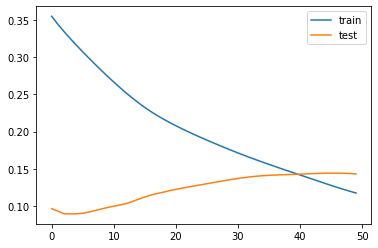

In [125]:
# fitting
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [126]:
# predict
y_hat = model.predict(X_test)

In [132]:
y_hat

array([[0.23309019, 0.3487661 , 0.25583488, 0.155836  , 0.11628881],
       [0.22705674, 0.3480566 , 0.24880213, 0.15568843, 0.1063413 ],
       [0.21776319, 0.3400656 , 0.24644688, 0.15371212, 0.10165057],
       [0.22442053, 0.34569377, 0.24453305, 0.15831518, 0.10445341]],
      dtype=float32)

In [134]:
y_test

array([[0.06756759, 0.06306314, 0.07207203, 0.06306314, 0.1036036 ],
       [0.06306314, 0.07207203, 0.06306314, 0.1036036 , 0.05855846],
       [0.07207203, 0.06306314, 0.1036036 , 0.05855846, 0.08558559],
       [0.06306314, 0.1036036 , 0.05855846, 0.08558559, 0.04504514]],
      dtype=float32)

In [129]:
# reverse the reshape for inverse scaling

# yhat_total, ytest_total = [], []
for i in range(y_hat.shape[0]):
  padding = np.zeros((y_hat.shape[1], X_test.shape[2])) # (samples, n_features)

  padding[:, TARGET_COL_IDX] = y_hat[i] # Close 컬럼 채워넣기
  inv_yhat = scaler.inverse_transform(padding)
  inv_yhat = inv_yhat[:, 1]
  # yhat_total.append(inv_yhat)

  padding[:, TARGET_COL_IDX] = y_test[i] # Close 컬럼 채워넣기
  inv_ytest = scaler.inverse_transform(padding)
  inv_ytest = inv_ytest[:, 1]
  # ytest_total.append(inv_ytest)
  print(
      f"NMAE *100 for ({i+1}/{y_hat.shape[0]}) : {nmae(inv_ytest, inv_yhat)[1]}"
      f"\n > y_true : {inv_ytest}"
      f"\n > y_hat  : {inv_yhat}"
  )
# yhat_total = np.array(yhat_total).reshape(1,-1)
# ytest_total = np.array(ytest_total).reshape(1,-1)

NMAE *100 for (1/4) : nan
 > y_true : [0. 0. 0. 0. 0.]
 > y_hat  : [0. 0. 0. 0. 0.]
NMAE *100 for (2/4) : nan
 > y_true : [0. 0. 0. 0. 0.]
 > y_hat  : [0. 0. 0. 0. 0.]
NMAE *100 for (3/4) : nan
 > y_true : [0. 0. 0. 0. 0.]
 > y_hat  : [0. 0. 0. 0. 0.]
NMAE *100 for (4/4) : nan
 > y_true : [0. 0. 0. 0. 0.]
 > y_hat  : [0. 0. 0. 0. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
